## Import

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
from model import (
    load_features,
    train_garch,
    forecast_garch,
    evaluate_models
)
from config import TEST_SIZE, RESULTS_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [22]:
df = load_features()
returns = df["log_return"]
target = df["target_volatility"]


## Chronological split

In [23]:
split_idx = int(len(df) * (1 - TEST_SIZE))

returns_train = returns.iloc[:split_idx]
returns_test = returns.iloc[split_idx:]
target_test = target.iloc[split_idx:]


## Rolling 1 step GARCH

In [24]:
garch_preds = []

for t in range(len(returns_test)):
    model = train_garch(returns.iloc[:split_idx + t])
    pred = forecast_garch(model, horizon=1)
    garch_preds.append(pred)


## Evaluate

In [25]:
metrics = evaluate_models(
    y_true=target_test.values,
    y_pred=garch_preds,
    model_name="GARCH"
)


## Save GARCH predictions

In [ ]:
garch_preds_df = pd.DataFrame({
    "target_vol": target_test.values,
    "garch_pred": garch_preds,
})
garch_preds_df.to_csv(RESULTS_DIR / "preds" / "garch_preds.csv", index=False)
print(f" Predictions saved to {RESULTS_DIR / 'preds' / 'garch_preds.csv'}")

 Predictions saved to C:\Users\hp\Financial-volatility-forecasting\results\preds\garch_preds.csv


## GARCH: Forecast vs Target Volatility

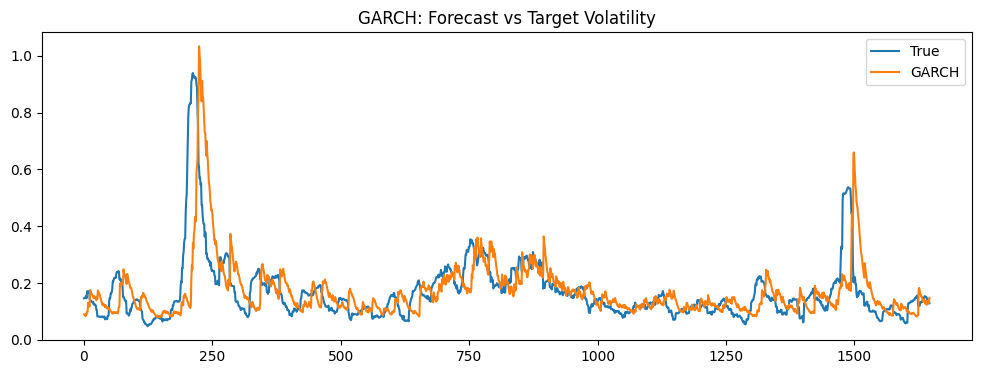

In [26]:
plt.figure(figsize=(12,4))
plt.plot(target_test.values, label="True")
plt.plot(garch_preds, label="GARCH")
plt.legend()
plt.title("GARCH: Forecast vs Target Volatility")
plt.savefig(f"{RESULTS_DIR}/figures/garch/GARCH_Forecast_vs_Target_Volatility.png", dpi=300, bbox_inches="tight")


## Save Metric

In [27]:
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(RESULTS_DIR / "metrics" / "garch_metrics.csv", index=False)
print(f"\n Metrics saved to {RESULTS_DIR / 'metrics' / 'garch_metrics.csv'}")


 Metrics saved to C:\Users\hp\Financial-volatility-forecasting\results\metrics\garch_metrics.csv
